### Ensembles: Bagging, Random Forests, and Boosting

Hillary Cheruiyot

<hr style="height:2pt">



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')

**Overview: Higgs Boson Discovery**

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

We are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to us is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [2]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [3]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [4]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

## Part 1: A Single Model

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this project, we do not need to standardize or normalize the predictors.

**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in the plot, but set the y-axis to focus on the cross-validation performance.

Helper functions for fitting regression trees of depth 1 to 24 on the training data and plotting cross-validation results. The range 1-24 was chosen by experimentation.

In [5]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [6]:
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [7]:
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

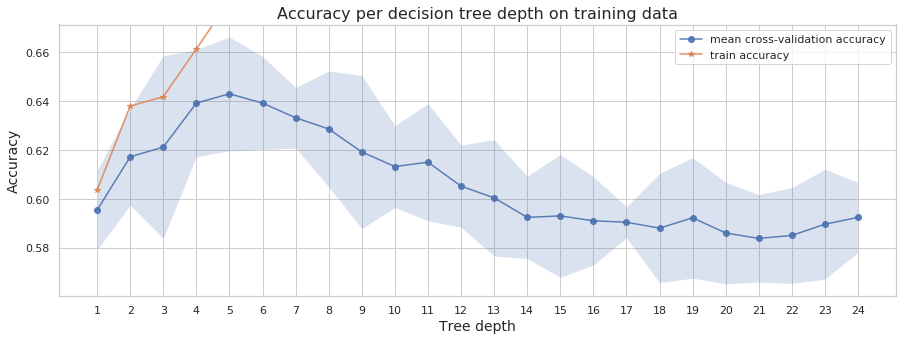

In [8]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 'Accuracy per decision tree depth on training data')

**1.2** Select an appropriate depth and justify the choice. Using the cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set.

In [9]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-5 tree achieves the best mean cross-validation accuracy 64.3 +/- 1.16619% on training dataset


We choose the above tree depth because it achieves the best average accuracy on training data using cross-validation folds with size 5. The lower bound of the confidence interval of the accuracy is high enough to make this value significant. When more nodes are added to the tree, it is clear that the cross-validation accuracy changes towards zero.  

The tree of depth 20 achieves perfect accuracy (100%) on the training set, this means that each leave of the tree contains exactly one sample and the class of that sample will be the prediction. That depth-20 tree is overfitting to the training set. The tree depth we chose via cross-validation helps us avoiding overfitting and gives better chance to reproduce the accuracy and generalize the model on test data.

In [10]:
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test

In [11]:
sm_best_tree_accuracy_train, sm_best_tree_accuracy_test = run_single_tree(X_train, y_train, X_test, y_test, sm_best_tree_depth)

Single tree depth:  5
Accuracy, Training Set:  68.12 %
Accuracy, Test Set:  64.8 %


**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth?

A full classification tree would split the training data until each leave contains a single observation. This tree would achieves a perfect classification of the training observations and the biais would be 0. In order words, the full tree would overfit to training data. Such a tree would be very sensitive because little changes of training observations would cause the predicted classes to change largely, this means the model variance would be very high.

By reducing the tree depth, we increase the biais (missclassification error on training) but we also reduce the variance. Bias-variance trade-off seeks a compromise between bias and variance, here using cross-validation. By resampling the data many times, splitting the into training and validation folds, fitting trees with different sizes on the training folds and looking at the classification accuracy on the validation folds, we are able to find the tree depth, which gives the best bias-variance trade-off, as we did above. Such a tree does not predict perfectly on the training set (acceptable bias) but its performance will be approximately the same if we change the training set a bit (acceptable variance).

## Part 2: Bagging

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this part we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.


**2.1** Choose a tree depth that will overfit the training set. What evidence leads we to believe that this depth will overfit?

We choose a tree depth for which the classification accuracy on training dataset is 100%, based on the plot we did in question 1. This tree overfits the training set because it always predict a class of a single observation in that set, and not the majority class of a larger region. As shown below it does not generalize well on the test set.

In [12]:
sm_overfit_tree_depth = 20
sm_overfit_accuracy_train, sm_overfit_accuracy_test = run_single_tree(X_train, y_train, X_test, y_test, sm_overfit_tree_depth)

Single tree depth:  20
Accuracy, Training Set:  100.0 %
Accuracy, Test Set:  60.28 %


**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth we just chose in 2.1. Record each tree's prediction.

In [13]:
def run_bagging(X_train, y_train, X_test, y_test, tree_depth, bagging_size=45):
    bagging_train = np.zeros((X_train.shape[0], bagging_size))
    bagging_test = np.zeros((X_test.shape[0], bagging_size))
    trees = []
    for i in range(bagging_size):
        X_train_bootstrap, y_train_bootstrap = resample(X_train, y_train)
        tree = DecisionTreeClassifier(max_depth=tree_depth).fit(X_train_bootstrap, y_train_bootstrap)
        bagging_train[:, i] = tree.predict(X_train)    
        bagging_test[:, i] = tree.predict(X_test)
        trees.append(tree)
    return bagging_train, bagging_test, trees

In [14]:
np.random.seed(0)
bagging_size = 45
bagging_train, bagging_test, bagging_trees = run_bagging(X_train, y_train, X_test, y_test, sm_overfit_tree_depth, bagging_size)

**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model we fit in 1.

In [15]:
def aggregate_bagging(bagging):
    return (bagging.sum(axis=1)/bagging.shape[1] > 0.5).astype('int')  

In [16]:
bagging_accuracy_train = accuracy_score(y_train, aggregate_bagging(bagging_train))
print('The bagging model achieves classification accuracy {}% on training dataset'.format(round(bagging_accuracy_train*100,5))) 

The bagging model achieves classification accuracy 99.96% on training dataset


In [17]:
bagging_accuracy_test = accuracy_score(y_test, aggregate_bagging(bagging_test))
print('The bagging model achieves {}% classification accuracy on test dataset.\nThe best single tree model achieved only {}% classification accuracy on test.'.format(round(bagging_accuracy_test*100,5), round(sm_best_tree_accuracy_test*100, 5))) 

The bagging model achieves 68.22% classification accuracy on test dataset.
The best single tree model achieved only 64.8% classification accuracy on test.


In [18]:
assert bagging_accuracy_test >= sm_best_tree_accuracy_test, "Bagging test accuracy too low"

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Make a plot of training and test set accuracies as a function of number of bootstraps.

On the plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth we chose in 2.1, trained on the full training set.


In [19]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [20]:
def plot_bagging_predictions(bagging_size, bagging_train, y_train, bagging_test, y_test, 
                             sm_best_tree_accuracy_test, sm_overfit_accuracy_test, title):
    bagging_accuracy_train = running_predictions(bagging_train, y_train)
    bagging_accuracy_test = running_predictions(bagging_test, y_test)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    bagging_sizes = range(1, bagging_size+1)
    ax.plot(bagging_sizes, bagging_accuracy_train, '-o', label='Bagging accuracy on training set', alpha=0.9)
    ax.plot(bagging_sizes, bagging_accuracy_test, '-x', label='Bagging accuracy on test set', alpha=0.9)
    ax.axhline(y=sm_best_tree_accuracy_test, label='Best single tree accuracy', alpha=0.9)
    ax.axhline(y=sm_overfit_accuracy_test, label='Overfit single tree accuracy', c='r', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Number of bootstraps', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xticks(bagging_sizes)
    ax.legend()
    #ax.grid(False)

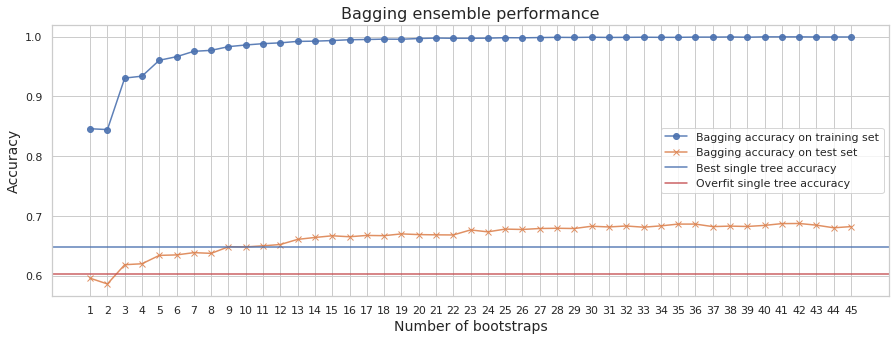

In [21]:
plot_bagging_predictions(bagging_size, bagging_train, y_train, bagging_test, y_test, sm_best_tree_accuracy_test, sm_overfit_accuracy_test, 'Bagging ensemble performance')

**2.5** Referring to the graph from 2.4, compare the performance of bagging against the baseline of a single depth-10 tree. Explain the differences we see.

In [22]:
print('The single depth-{} tree picked in 2.1 achieves {}% classification accuracy on training set and {}% on test set.'.format(sm_overfit_tree_depth,round(sm_overfit_accuracy_train*100,5), round(sm_overfit_accuracy_test*100,5)))
print('Bagging with depth-{} tree achieves {}% classification accuracy on training set and {}% on test set.'.format(sm_overfit_tree_depth,round(bagging_accuracy_train*100,5), round(bagging_accuracy_test*100,5)))
print('The single depth-{} tree chosen in 1.5 achieves {}% classification accuracy on training set and {}% on test set.'.format(sm_best_tree_depth,round(sm_best_tree_accuracy_train*100,5), round(sm_best_tree_accuracy_test*100,5)))

The single depth-20 tree picked in 2.1 achieves 100.0% classification accuracy on training set and 60.28% on test set.
Bagging with depth-20 tree achieves 99.96% classification accuracy on training set and 68.22% on test set.
The single depth-5 tree chosen in 1.5 achieves 68.12% classification accuracy on training set and 64.8% on test set.


Looking at the plot from 2.4, by fitting a depth-20 tree on 3 or more bootstraps of the training set and averaging their classifications by majority vote, we achieve better classification accuracy on test (orange line) compared to using a single depth-20 tree (red line). 

With bagging we are averaging the variances introduced by overfitting the original depth-20 tree to training data. This results in less overfitting, and better performance on test, even better than the best single tree tuned via cross-validation.



**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches.

* **limiting tree depth**: the big depth-20 tree from 2.1 has a high number of parameters and overfits training data, especially because we end up with a tree where each leave is classifying one training sample (accuracy 100%). In order to avoid overfitting and reduce variance, we can stop building the tree when the leaves are pure, or when leaves have a specific size or when the gain of adding nodes is less than a given threshold. Ultimately we found the best 5-depth tree via cross-validation in 1.2. 

* **bagging**: by sampling with replacement, bagging creates several large low-bias depth-20 trees fitted to bootstraped training data. Assuming that the trees are independent, we averaged their predictions in order to reduce variance and solve overfitting. The large tree size captures most information in the training dataset, resulting in low bias. Bagging with 20 or more trees improves test accuracy (68.22%), compared to a single 5-depth tree (64.8%), as shown in 2.4. 





**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

Even with bagging we can still overfit the data, especially when the trees are correlated. In such case, the total variance is not just the average of individual variances, but a whole buch of covariance terms are also taken into consideration. This is because Bagging will most probably pick the same predictors at the beginning for the first split of the trees. Random forests come into play to solve this issue.

Bagging can also underfit. This is the case when the tree depth is too low. Additionally since through boostrap we do not use all data for training, we can end up with underfitting to the whole training dataset. The out-of-bag samples can however be used to validate the trees. 

It is to be noted that bagging will not help if we have very high biais. 

## Part 3: Random Forests

Random Forests are closely related to the bagging model we built by hand in part 2. In this part we compare our by-hand results with the results of using `RandomForestClassifier` directly.







**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.



**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that we used in 2.2. Evaluate its accuracy on the test set.

In [23]:
def run_random_forest(X_train, y_train, X_test, y_test, size, depth):
    randomf = RandomForestClassifier(n_estimators=size, max_depth=depth).fit(X_train, y_train)
    accuracy_train = randomf.score(X_train, y_train)
    accuracy_test = randomf.score(X_test, y_test)
    print('RANDOM FOREST')
    print('Number of trees: ', size)
    print('Tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test, randomf

In [24]:
rf_accuracy_train, rf_accuracy_test, randomf = run_random_forest(X_train, y_train, X_test, y_test, bagging_size, sm_overfit_tree_depth)

RANDOM FOREST
Number of trees:  45
Tree depth:  20
Accuracy, Training Set:  99.96 %
Accuracy, Test Set:  68.34 %


**3.2** For each of the decision trees we fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest we just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

In [25]:
top_features_occurencies = np.zeros((data_train.shape[1], 2))
for i in range(bagging_size):
    bagging_top_feature_idx = bagging_trees[i].tree_.feature[0]
    randomf_top_feature_idx = randomf.estimators_[i].tree_.feature[0]
    top_features_occurencies[bagging_top_feature_idx, 0] += 1    
    top_features_occurencies[randomf_top_feature_idx, 1] += 1

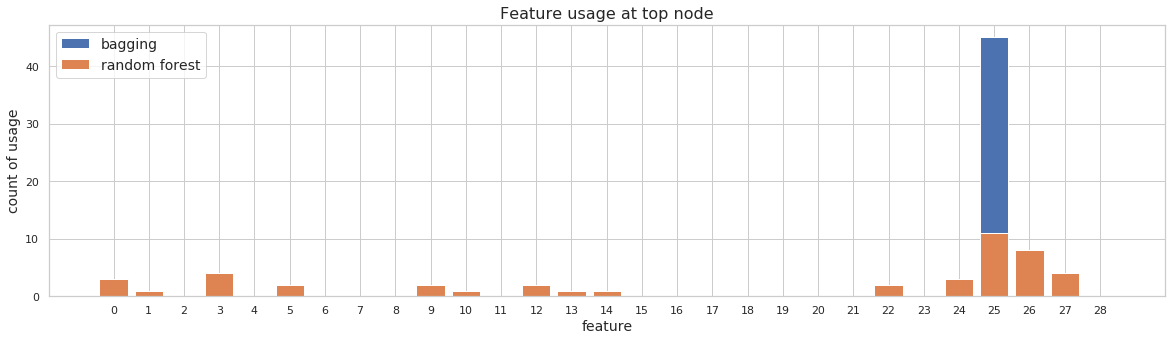

In [26]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.bar(np.arange(data_train.shape[1]),top_features_occurencies[:,0], label='bagging')
ax.bar(np.arange(data_train.shape[1]),top_features_occurencies[:,1], label='random forest')
ax.set_xticks(np.arange(data_train.shape[1]))
ax.set_xlabel('feature', fontsize=14)
ax.set_ylabel('count of usage', fontsize=14)
ax.legend(fontsize=14)
ax.set_title('Feature usage at top node', fontsize=16);

Bagging tends to always choose the same feature nr. 25 (**m_bb**) as root feature for all 45 boostrap trees. Feature nr. 25 provides the best first split of data in two regions with minimal Gini impurity. Therefore the trees will all be correlated, at least at their top nodes. This results in overfitting to training data by bagging and lost of classification accuracy on test.

Random Forest does not use the full set of 29 features as bagging does. At each split when fitting the trees, random forest rather selects a subset of predictors, randomly. It then search for the feature within that subset, as well as a threshold value that provides the most optimal split (via Gini, entropy, etc.). The size of the random subset, usually the sqrt of the total number of features, can be found via cross-validation using the unused samples after bootstrapping (out-of-bag). As a result with Random Forest, 15 out of 29 features appear at the top of our 45 trees. A down-side of random forests is: if many of our 29 features are irrelevant, Random Forest might end up choosing the less relevant ones, resulting in a poor tree. In such case we might want to do some pre-check using cross-correlation and features selection. 

Random Forest achieves slightly better classification accuracy on test, compared to bagging. This is because Random Forest de-correlates the trees and aids reducing the variance in the results, even more than bagging, since with random forest covariance terms between trees are reduced. 

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from 1)
- A single overfit tree trained on all data (from 2, using the depth we chose there)
- Bagging 45 such trees (from 2)
- A Random Forest of 45 such trees (from 3.1)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

In [27]:
classifier = ['single tree with best depth-5 chosen by CV','single depth-20 tree','bagging 45 depth-20 trees','Random Forest of 45 depth-20 trees']
training_accuracy = [sm_best_tree_accuracy_train, sm_overfit_accuracy_train, bagging_accuracy_train, rf_accuracy_train]
test_accuracy = [sm_best_tree_accuracy_test, sm_overfit_accuracy_test, bagging_accuracy_test, rf_accuracy_test]
models_benchmark_df = pd.DataFrame({'classifier':classifier, 'training accuracy': training_accuracy, 'test accuracy': test_accuracy})
models_benchmark_df

,classifier,training accuracy,test accuracy
0,single tree with best depth-5 chosen by CV,0.6812,0.6480
1,single depth-20 tree,1.0000,0.6028
2,bagging 45 depth-20 trees,0.9996,0.6822
3,Random Forest of 45 depth-20 trees,0.9996,0.6834


**Performance**

The fully grown depth-20 tree leads to almost 100% accuracy on training set (also with bagging and random forest), in contrast to the single tree with best depth-5 chosen by CV, which achieves only 68.12% accuracy on training set. The bottom side of the CV approach is that by stopping too soon, we missed out some information in the training dataset and we end up with high bias (only 64.8% test accuracy with depth-5 tree).

Bagging and random forest reduce overfitting and improves the accuracy on test set.

**Bias-variance trade-off**

* CV provides the lowest variance (less overfit to training set) at the cost of highest bias. The low tree depth did not allow to catch additional information in the data; we stopped building the tree too early.
* The depth-20 tree is not robust and leads to too much variance. Bagging and random forest reduce variance and lead to the lower bias, compared to the single depth-5 tree.

## Part 4: Boosting

In this part we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do we notice any predictors for which the distributions are clearly different?

In [28]:
tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

y_train_predicted_tree1 = tree1.predict(X_train)

y_train_predicted_tree1_bool = y_train_predicted_tree1 == y_train
X_train_correct = X_train[y_train_predicted_tree1_bool]
X_train_wrong = X_train[np.logical_not(y_train_predicted_tree1_bool)]

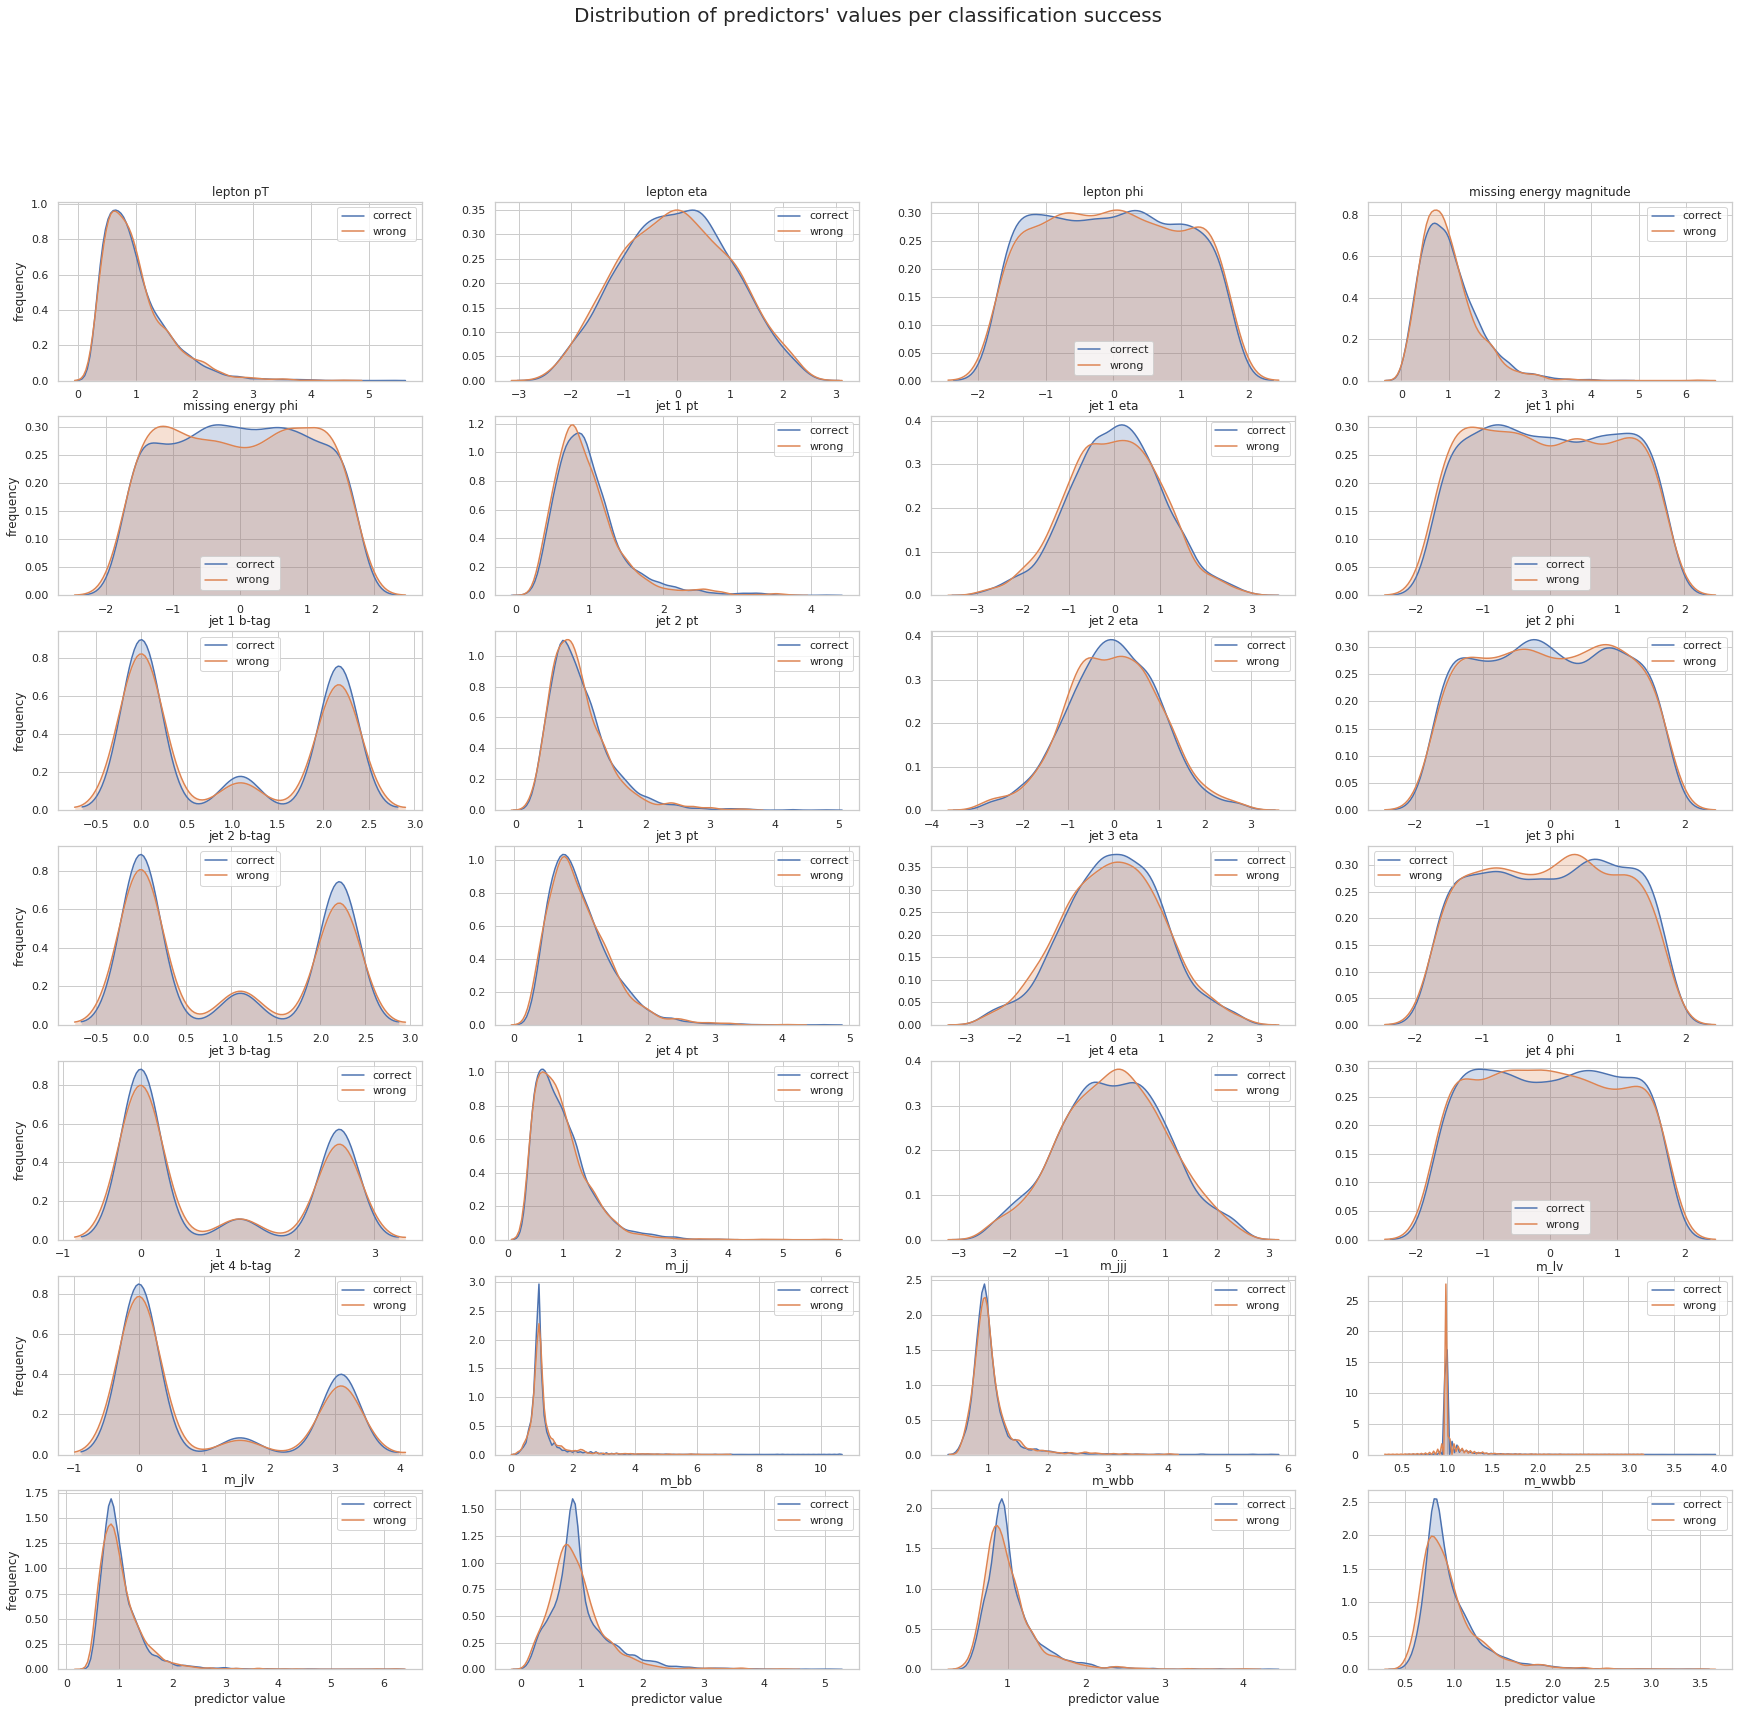

In [29]:

fig, axs = plt.subplots(7, 4, figsize=(30, 27))
i = 0;
for ax in axs.ravel():
    sns.kdeplot(X_train_correct[:,i], ax=ax, shade=True, label='correct')    
    sns.kdeplot(X_train_wrong[:,i], ax=ax, shade=True, label='wrong')
    ax.set_title(data_train.columns[i])
    if i >= 24:        
        ax.set_xlabel('predictor value')
    if i%4 == 0:
        ax.set_ylabel('frequency')
    i += 1
fig.suptitle("Distribution of predictors' values per classification success", fontsize=20);

The distribution of samples' values for correct vs. wrong predictions is almost identical. This evidence suggests that the likeliwood that a sample could be missclassified does not depend on its value. Therefore we can improve the predictive capability of the tree by combining it with another tree trained on miss-classification information. This is the motivation behind doing boosting. 

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers. Compare the performance of `tree1` and the boosted algorithm on both the training and test set.

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [30]:
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
      if tree1.predict([X_train[idx]]) != y_train[idx]:
         sample_weight[idx] = sample_weight[idx] * 2
         q = q + 1
    print("tree1 accuracy:", 1-q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

tree1 accuracy: 0.6417999999999999
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


* the predictions can be made outside the for loop for the whole training dataset instead of sample-wise
* the weight 2 could be assigned directly instead of doing a multiplication 1 * 2
* the count of successfully predicted samples can be done using boolean arrays
* the tree accuracy appears to be the misscalssification rate. It might be better to use the sklearn accuracy_score function.
* the whole for loop can be replace by np array operations, which are faster
* the X_train and y_train can be given as function parameters



In [31]:
tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

y_train_predicted_tree1 = tree1.predict(X_train)
y_test_predicted_tree1 = tree1.predict(X_test)

y_train_predicted_tree1_bool = y_train_predicted_tree1 == y_train

sample_weights = np.ones(len(X_train))
sample_weights[np.logical_not(y_train_predicted_tree1_bool)] = 2

tree2 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train, sample_weight=sample_weights)
y_train_predicted_tree2 = tree2.predict(X_train)
y_test_predicted_tree2 = tree2.predict(X_test)

y_train_predicted_boosted = ((tree1.predict_proba(X_train)[:,1] + tree2.predict_proba(X_train)[:,1])/2 > 0.5).astype('int')
y_test_predicted_boosted = ((tree1.predict_proba(X_test)[:,1] + tree2.predict_proba(X_test)[:,1])/2 > 0.5).astype('int')

In [32]:
models_benchmark_df = models_benchmark_df.append(pd.DataFrame({'classifier':['single depth-3 tree', 'single depth-3 tree with updated weights', 'manually boosted depth-3 tree'],
              'training accuracy': [accuracy_score(y_train, y_train_predicted_tree1),
                                    accuracy_score(y_train, y_train_predicted_tree2),
                                    accuracy_score(y_train, y_train_predicted_boosted)],
              'test accuracy': [accuracy_score(y_test, y_test_predicted_tree1),
                                    accuracy_score(y_test, y_test_predicted_tree2),
                                    accuracy_score(y_test, y_test_predicted_boosted)]}))
models_benchmark_df.drop_duplicates()

,classifier,training accuracy,test accuracy
0,single tree with best depth-5 chosen by CV,0.6812,0.6480
1,single depth-20 tree,1.0000,0.6028
2,bagging 45 depth-20 trees,0.9996,0.6822
3,Random Forest of 45 depth-20 trees,0.9996,0.6834
0,single depth-3 tree,0.6418,0.6442
1,single depth-3 tree with updated weights,0.6134,0.6088
2,manually boosted depth-3 tree,0.6488,0.6510


**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

In [33]:
def run_adaboosting(X_train, y_train, X_test, y_test, depths=[3], iterations=800, lr=0.05):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ab_train_scores = np.zeros((iterations, len(depths)))
    ab_test_scores = np.zeros((iterations, len(depths)))
    for i, depth in enumerate(depths):
        ab_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=iterations, learning_rate=lr)
        ab_model.fit(X_train, y_train);
        train_scores = list(ab_model.staged_score(X_train,y_train))
        test_scores = list(ab_model.staged_score(X_test, y_test))
        ab_train_scores[:, i] = np.array(train_scores)
        ab_test_scores[:, i] = np.array(test_scores)
        ax[0].plot(train_scores,label='depth-{}'.format(depth))
        ax[1].plot(test_scores,label='depth-{}'.format(depth))
    ax[0].set_xlabel('number of iterations', fontsize=12)
    ax[1].set_xlabel('number of iterations', fontsize=12)
    ax[0].set_ylabel('Accuracy', fontsize=12)
    ax[0].set_title("Variation of Accuracy with Iterations (training set)", fontsize=14)
    ax[1].set_title("Variation of Accuracy with Iterations (test set)", fontsize=14)
    ax[0].legend(fontsize=12);
    ax[1].legend(fontsize=12);
    return ab_train_scores, ab_test_scores
    

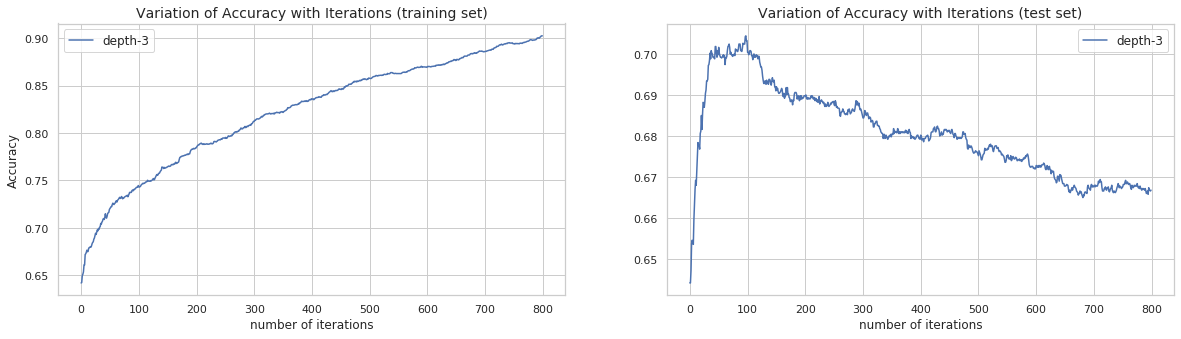

In [34]:
ab_train_scores, ab_test_scores = run_adaboosting(X_train, y_train, X_test, y_test)

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do we see in the training and test accuracy?

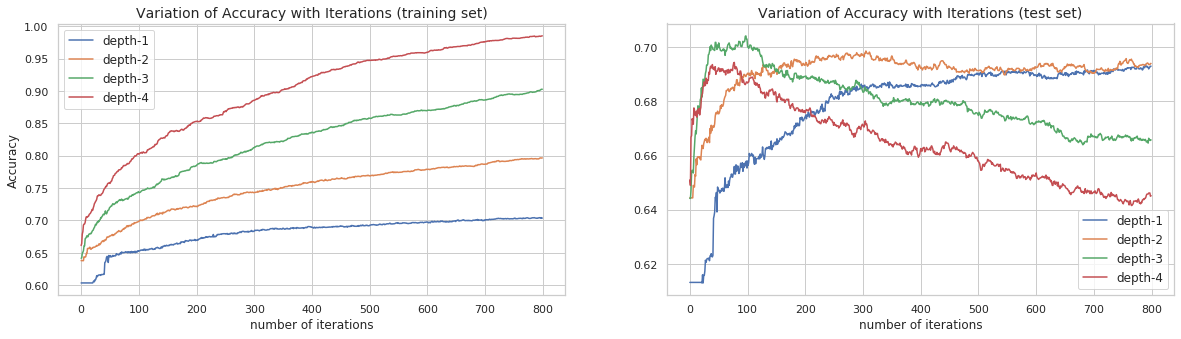

In [35]:
tree_depths = [1,2,3,4]
ab_train_scores, ab_test_scores = run_adaboosting(X_train, y_train, X_test, y_test, depths=tree_depths)

With boosting we learn from the residuals of the previous tree in each new iteration, therefore we observe an increasing training set accuracy until we will overfit the data and observe a steady state close to 100%. 

The tree depth affects the trends pretty much. The training set accuracy is higher with bigger trees, regardless the number of iterations. The variation of test set accuracy is not consistent for different tree depths. Depth-1 and depth-2 trees can be considered as very slow learners, which require a higher number of iterations. Depth-3 and depth-4 trees are learning faster; the test set accuracy increases steadily during the first iterations until it reaches a peak, then it decreases with increasing number of iterations. While depth-1 and depth-2 trees underfit the data, depth-4 tree overfits the most. The lowest variance and lowest biais is suggested by depth 3.




**4.5** Based on the plot we just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles we considered above?

In [36]:
best_nb_iterations = np.array([ab_test_scores[:,i].argmax() for i in range(len(tree_depths)) ])
best_test_scores = np.array([ab_test_scores[best_nb_iterations[i],i] for i in range(len(tree_depths)) ])
optimal_tree_depth_idx = best_test_scores.argmax()
optimal_nb_iterations = best_nb_iterations[optimal_tree_depth_idx]
optimal_tree_depth = tree_depths[optimal_tree_depth_idx]
optimal_test_score = ab_test_scores[optimal_nb_iterations, optimal_tree_depth_idx]
optimal_train_score = ab_train_scores[optimal_nb_iterations, optimal_tree_depth_idx]
print('The combination of base learner depth {} and {} iterations achieves the best accuracy {}% on test set and {}% on training set.'.format(optimal_tree_depth, optimal_nb_iterations, round(optimal_test_score*100,5), round(optimal_train_score*100,5))) 

The combination of base learner depth 3 and 97 iterations achieves the best accuracy 70.42% on test set and 74.28% on training set.


In [37]:
models_benchmark_df = models_benchmark_df.append(pd.DataFrame({'classifier':['ada-boosted depth-3 tree'],
              'training accuracy': [optimal_train_score],
              'test accuracy': [optimal_test_score]}))

Ada-boosted depth-3 decisision tree classifier obtained after 97 boosting iterations seems optimal in terms of low variance and low bias. Ada-boosting achieves better accuracy than the manually boosted depth-3 tree using updated weights in question 4.2. The improved accuracy suggests that ada-boosting actually helps quite much. 

## Part 5: Understanding


**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

Bagging and boosting are so-called 'ensemble' techniques, which by aggregating many weak-learner models such as single decision trees, substantially improve the predictive accuracy.

Bagging works by fitting a weak-learner to multiple boostraps of the same data and aggregating their predictions into a single outcome. Although bagging can be parallelized, boosting works sequentially by starting with a weak-learner and adding up a new model trained on residuals of the weak-learner. This process is repeated several times and each model is trained by a modified version of the original dataset, regularized using a learning rate. 

**5.2** Reflect on the overall performance of all of the different classifiers we have seen throughout this assignment. Which performed best? Why do we think that may have happened?

In [38]:
models_benchmark_df.drop_duplicates()

,classifier,training accuracy,test accuracy
0,single tree with best depth-5 chosen by CV,0.6812,0.6480
1,single depth-20 tree,1.0000,0.6028
2,bagging 45 depth-20 trees,0.9996,0.6822
3,Random Forest of 45 depth-20 trees,0.9996,0.6834
0,single depth-3 tree,0.6418,0.6442
1,single depth-3 tree with updated weights,0.6134,0.6088
2,manually boosted depth-3 tree,0.6488,0.6510
0,ada-boosted depth-3 tree,0.7428,0.7042


Ada-boosting performs the best. Instead of fitting a single large decision tree to the data with potentially overfitting, our Ada-boosted model learns slowly on updated versions of training data using a smaller tree.  

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

Unlike bagging, boosting can overfit if the number of trees is too large. This overfit can be avoid by choosing number of trees via cross-validation. The number of trees is no a critical parameter for bagging, a large number will not lead to overfitting because of the aggregation. With bagging we are able to squeeze out the variance. With boosting a large number of trees we fit down to each single residual and end up fitting the model to each single sample of the training set. This overfitting can be avoided by regularization or by early stopping as soon as the validation loss starts raizing.  

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where we could have multiple computers working on a problem at the same time?

Each tree in bagging can be trained independently of the others. Therefore bagging technique is better suited to parallelization for example on a multi-core CPU computer. Boosting is sequential since each tree is built using the previous one.


**5.5** Which of these techniques can be extended to regression tasks? How?

Bagging can improve prediction for many regression methods such as least-square linear regression, by fitting a linear regression model to multiple training datasets obtained via bootstrap and averaging the resulting predictions. Moreover the out-of-bag samples can be used for validation.

Boosting can be applied to regression tasks as well. Here we do not work on boostraped data, instead we fit a model on the original data, the next model is fit on the residuals obtained; the predictions of both models are weighted with the learning rate and summed up.